In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Conv2D , MaxPool2D , Flatten , Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

In [2]:
dataset, dataset_info = tfds.load("malaria", with_info=True, split =['train[:80%]', 'train[80%:90%]','train[90%:]'], shuffle_files= True )

In [3]:
dataset

[<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>]

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Lenovo\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin

In [5]:
train_dataset = dataset[0]
val_dataset = dataset[1]
test_dataset = dataset[2]

In [6]:
def get_label_str(label):
    if(label == 0):
        return "Parasitized"
    else:
        return "Uninfected"

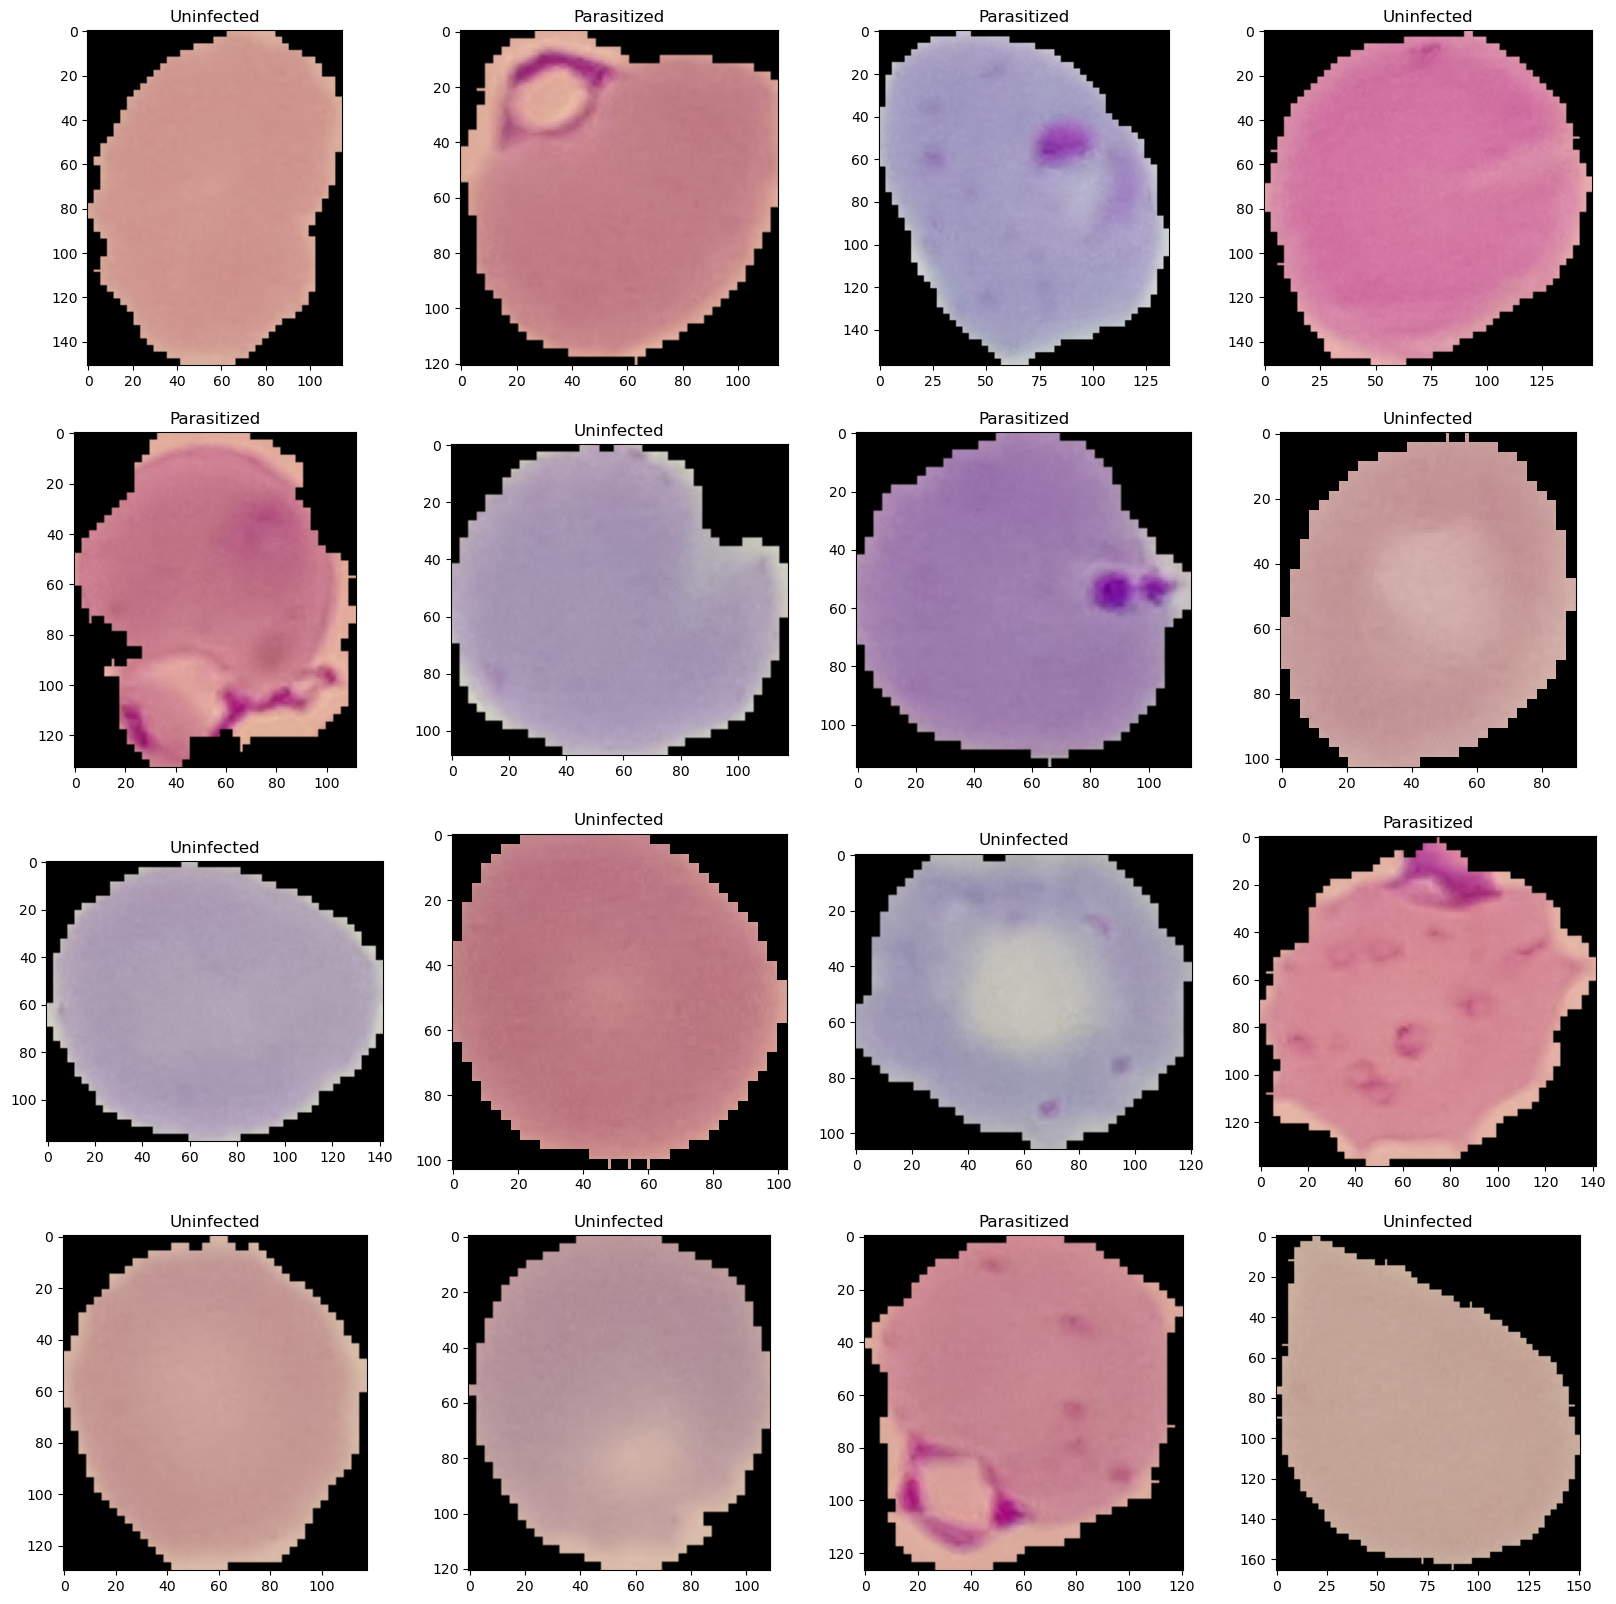

In [7]:
fig = plt.figure(figsize=(20,20))

for i, sample in enumerate(train_dataset.take(16)):
    ax = fig.add_subplot(4,4, i+1)
    plt.imshow(sample['image'])
    plt.title(get_label_str(sample['label'].numpy()))

In [8]:
def resize_rescale(inputs):
    return tf.image.resize(inputs['image'], (224,224))/255., inputs['label']

In [9]:
train_dataset = train_dataset.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
#LeNet Architecture
model = tf.keras.Sequential([
    InputLayer(input_shape = (224,224,3)),
    Conv2D(filters =6 , kernel_size =3 , strides =1 , padding ='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size =2 , strides =2),

    Conv2D(filters =6 , kernel_size =3 , strides =1 , padding ='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size =2 , strides =2),

    Flatten(),

    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')

])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 6)       330       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 6)      24        
 hNormalization)                                                 
                                                      

In [25]:
model.compile(
    optimizer = Adam(learning_rate=0.01),
    loss = BinaryCrossentropy(),
    metrics = BinaryAccuracy(),)

In [27]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs = 6,
    verbose = 1)

Epoch 1/6
689/689 [==============================] - 186s 270ms/step - loss: 0.1445 - binary_accuracy: 0.9516 - val_loss: 0.2176 - val_binary_accuracy: 0.9419
Epoch 2/6
689/689 [==============================] - 186s 270ms/step - loss: 0.1382 - binary_accuracy: 0.9556 - val_loss: 0.1955 - val_binary_accuracy: 0.9369
Epoch 3/6
689/689 [==============================] - 187s 271ms/step - loss: 0.1330 - binary_accuracy: 0.9575 - val_loss: 0.3632 - val_binary_accuracy: 0.8327
Epoch 4/6
689/689 [==============================] - 187s 271ms/step - loss: 0.1196 - binary_accuracy: 0.9614 - val_loss: 0.3880 - val_binary_accuracy: 0.7968
Epoch 5/6
689/689 [==============================] - 193s 280ms/step - loss: 0.1148 - binary_accuracy: 0.9632 - val_loss: 0.2167 - val_binary_accuracy: 0.9271
Epoch 6/6
689/689 [==============================] - 193s 280ms/step - loss: 0.1122 - binary_accuracy: 0.9616 - val_loss: 0.2180 - val_binary_accuracy: 0.9336


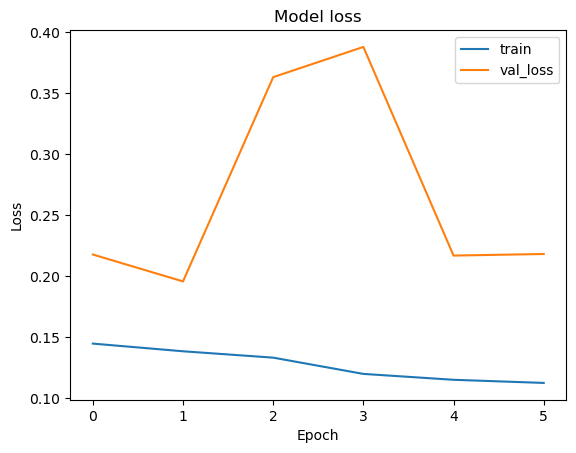

In [28]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['train', 'val_loss'])
plt.show()

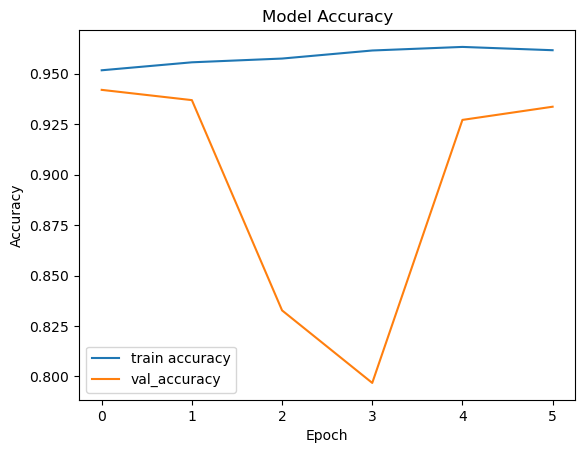

In [29]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train accuracy', 'val_accuracy'])
plt.show()

In [30]:
model.evaluate(test_dataset)

87/87 [==============================] - 5s 58ms/step - loss: 0.2006 - binary_accuracy: 0.9365


[0.2005763202905655, 0.9365021586418152]

In [31]:
def parasite_or_not(x):
    if x<0.5:
        return str('P')
    else:
        return str('U')

In [32]:
print(parasite_or_not(model.predict(test_dataset.take(1))[0][0]))

1/1 [==============================] - 0s 263ms/step
P


1/1 [==============================] - 0s 68ms/step


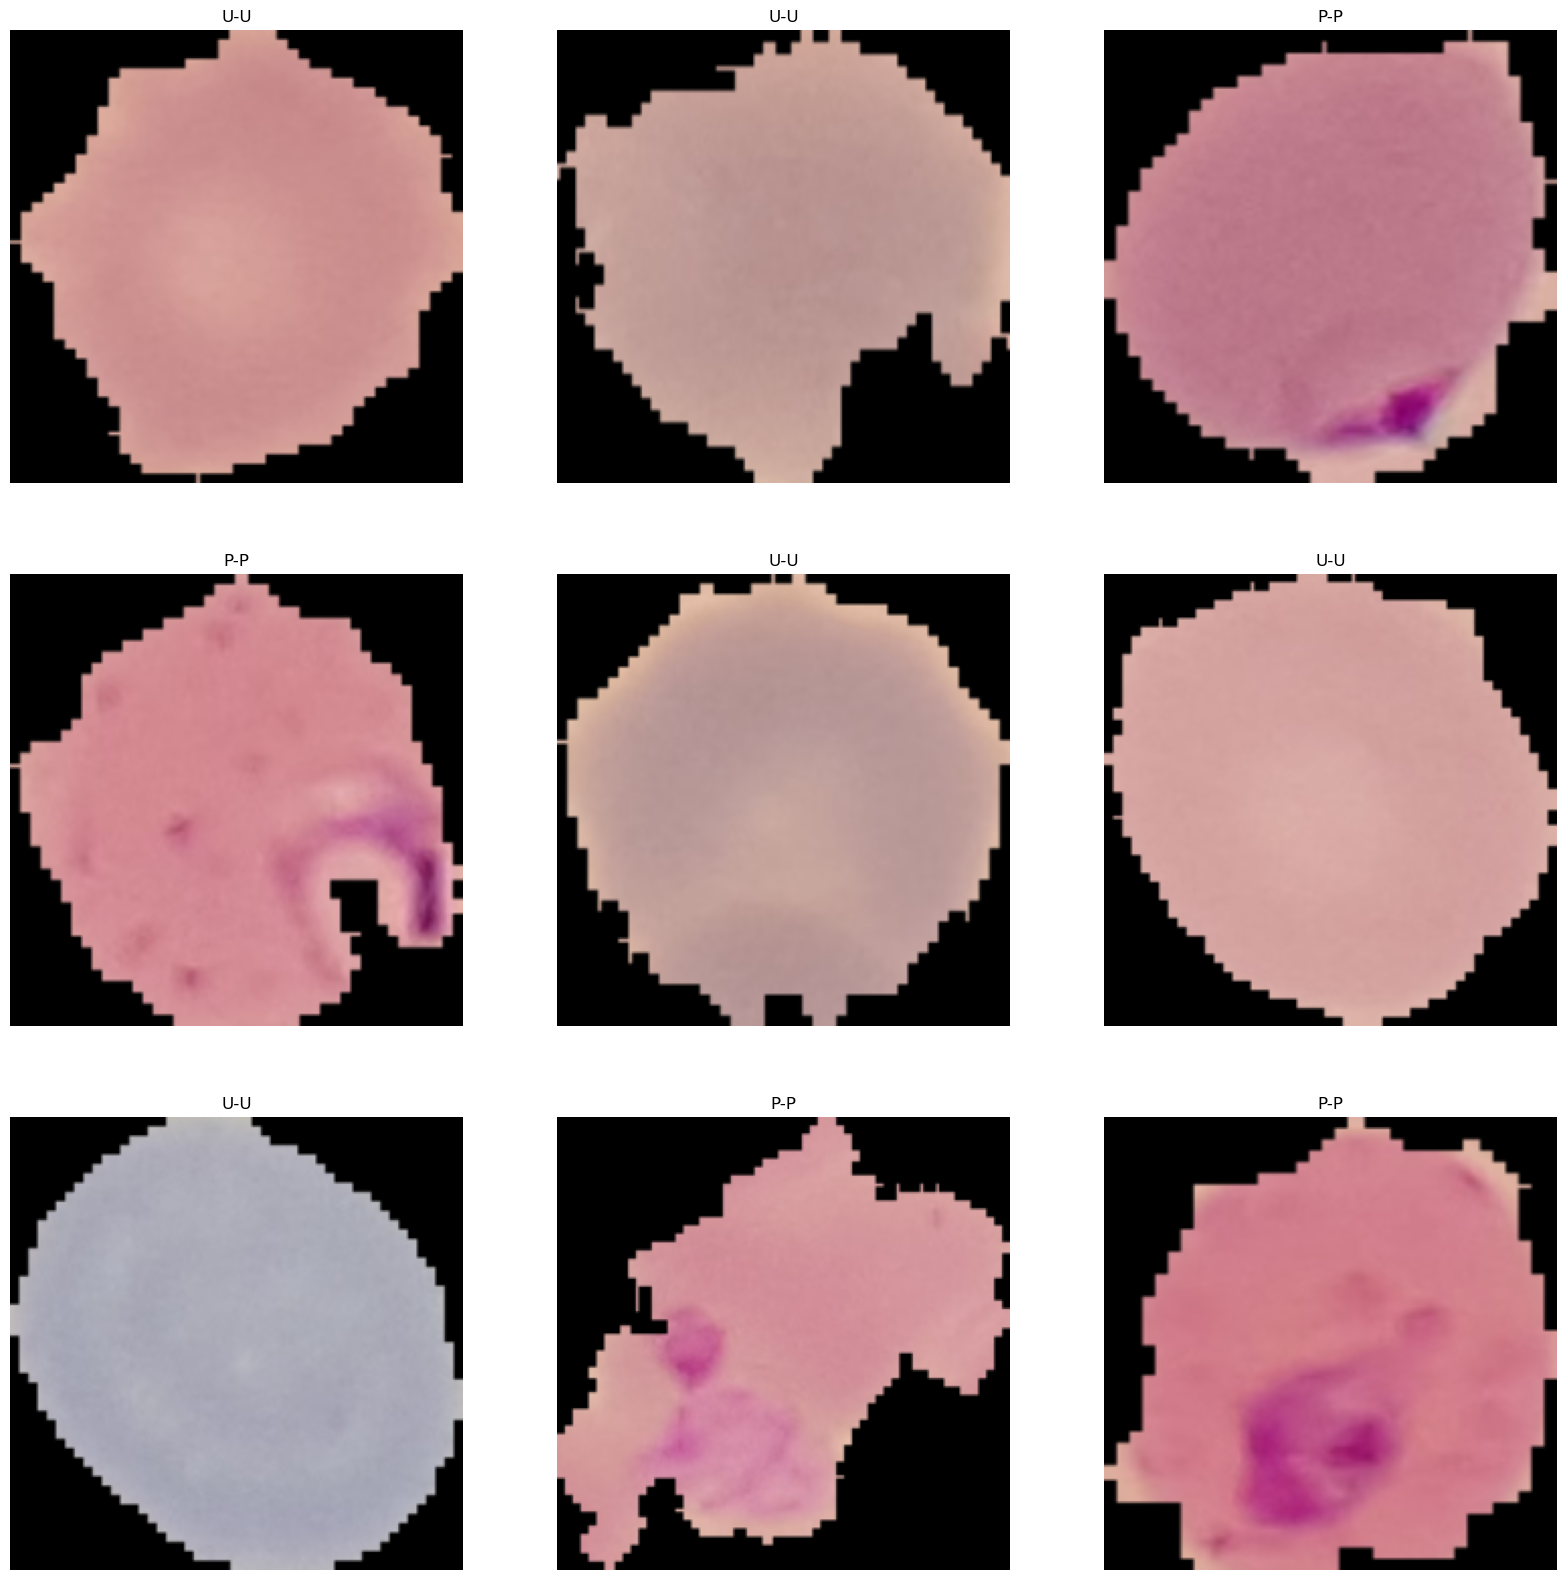

In [35]:
fig = plt.figure(figsize=(20,20))

for image,label in test_dataset.take(1):
    for i in range(9):
        ax = fig.add_subplot(3,3, i+1)
        plt.imshow(image[i])
        plt.title(parasite_or_not(label.numpy()[i])+"-"+parasite_or_not(model.predict(image)[i][0]))
        plt.axis('off')

In [36]:
model.save("LeNetModelMalaria")
#the above methods saves the config and weights, to save just the weights, use .save_weights() 

INFO:tensorflow:Assets written to: LeNetModelMalaria\assets


INFO:tensorflow:Assets written to: LeNetModelMalaria\assets


In [37]:
#to load model
loaded_model = tf.keras.models.load_model("LeNetModelMalaria")